In [ ]:
import pybullet as p
import pybullet_data
import pkgutil
import numpy as np
import time

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [33]:
import pickle

# load data from file
file = open("../for_preston/default_sim/train.p", "rb")
data = pickle.load(file)[0]
file.close()

file = open('../for_preston/default_sim.p', 'rb')
traj_data = pickle.load(file)
file.close()
traj_data

['default_sim',
 [11, array([[1. , 0. , 0.5, 0. ],
         [0. , 1. , 0. , 0.5],
         [0. , 0. , 1. , 0. ],
         [0. , 0. , 0. , 1. ]]), array([[0.125, 0.   ],
         [0.   , 0.125],
         [0.5  , 0.   ],
         [0.   , 0.5  ]]), array([[2., 0., 0., 0.],
         [0., 2., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]), array([[1000.,    0.],
         [   0., 1000.]]), 8, array([0., 0.]), array([3.6576, 2.7432]), -0.2, 0.2, -0.11961722488038279, 0.11961722488038279],
 ['x0', 'xg', 'obstacles']]

In [26]:
# helper functions to add plane + obstacles

def add_obstacle(obstacle, height=0.2):
    half_extents = [(obstacle[1]-obstacle[0])/2, (obstacle[3]-obstacle[2])/2, height/2]
    pos = [(obstacle[0] + obstacle[1])/2, (obstacle[2] + obstacle[3])/2, height/2]
    obs_vis_id = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extents)
    obs_coll_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extents)
    p.createMultiBody(baseCollisionShapeIndex=obs_coll_id, baseVisualShapeIndex=obs_vis_id, 
                      basePosition=pos)

def add_ground_plane():
    half_extents = [0.3048*0.5*12, 0.3048*0.5*9, 0.01]
    obs_vis_id = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extents, rgbaColor=[0.2, 0.2, 0.2, 1.])
    obs_coll_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extents)
    p.createMultiBody(baseCollisionShapeIndex=obs_coll_id, baseVisualShapeIndex=obs_vis_id, 
                      basePosition=half_extents)
    

ven = NVIDIA Corporation
ven = NVIDIA Corporation
Destroy EGL OpenGL window.
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 470.63.01
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 470.63.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
body(1.7925153803056395, 1.483016197660139, 0.2870919038953259) (-0.21785788330280742, 0.20313210018629696, 0.6761597059439404, 0.6738570654185713)


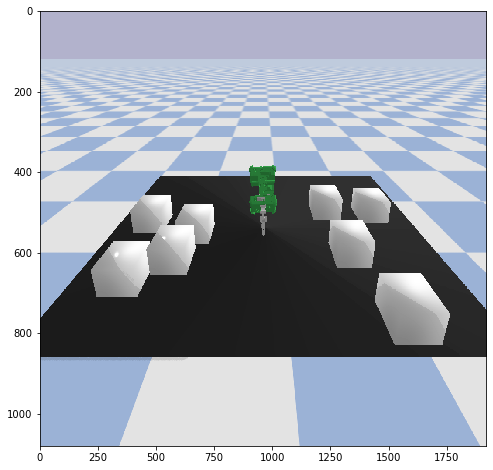

In [30]:
# main scrippt
obs_data = data['obstacles'][0, :, :]

# PyBullet setup.
egl = pkgutil.get_loader('eglRenderer')
physicsClient = p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally
plugin = p.loadPlugin(egl.get_filename(), "_eglRendererPlugin")
p.setGravity(0,0,-10)

# Load models from pybullet_data.
planeId = p.loadURDF("plane.urdf")
startPosition = [1.8,1.4,1]
startOrientation = p.getQuaternionFromEuler([0,0,np.pi/2])
astrobee = p.loadURDF("AstrobeeRobot.jl/deps/Astrobee/astrobee.urdf", 
                      basePosition=startPosition, baseOrientation=startOrientation,
                      flags=p.URDF_USE_INERTIA_FROM_FILE)

fps = 30
nSeconds = 5
nFrames = nSeconds * fps

# Image params.
pixelWidth = w = 1920
pixelHeight = h = 1080
camTargetPos = [1.8, 1.4, 0]
camDistance = 3
pitch = -25.0
roll = 0
yaw = 0.
upAxisIndex = 2
viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch, roll,
                                                 upAxisIndex)
projectionMatrix = [
    1.0825318098068237, 0.0, 0.0, 0.0, 0.0, 1.732050895690918, 0.0, 0.0, 0.0, 0.0,
    -1.0002000331878662, -1.0, 0.0, 0.0, -0.020002000033855438, 0.0
]

# matplotlib setup.
fig = plt.figure( figsize=(8,8) )
im = plt.imshow(np.random.rand(pixelHeight, pixelWidth), interpolation='none', aspect='auto', vmin=0, vmax=1)

# Sim setup -- add plane + obs.
add_ground_plane()
for ii in range(len(obs_data[0])):
    add_obstacle([obs_data[jj][ii] for jj in range(4)])

# main animation loop:
renderings = []
for ii in range (nFrames):
    p.stepSimulation() # TODO(pculbert): step through trajectory instead of 
    img_arr = p.getCameraImage(pixelWidth,
                           pixelHeight,
                           viewMatrix=viewMatrix,
                           projectionMatrix=projectionMatrix,
                           shadow=1,
                           lightDirection=[1, 1, 1])
    renderings.append(img_arr[2].reshape((h, w, 4)) * (1. / 255.))

def animate_func(ii):
    im.set_array(renderings[ii])
    return [im]

anim = animation.FuncAnimation(
                               fig,
                               animate_func,
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim.gif', writer=animation.PillowWriter(fps=fps))

cubePos, cubeOrn = p.getBasePositionAndOrientation(boxId)
print(cubePos,cubeOrn)

p.disconnect()
plt.show()